In [2]:
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm
from scipy.integrate import solve_ivp

In [304]:
k

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.72238535e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.16258371e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.83161616e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.37734652e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.87292207e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.82118824e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,

In [3]:
#slow mode

In [4]:
k = np.genfromtxt('k.csv', delimiter=',')
K = np.genfromtxt('KK.csv', delimiter=',')
lam = 5
g = k.shape[0]

In [604]:
#no slow mode
g = 30
lam = 5
is_connected = np.random.rand(g,g) < .25
is_connected = np.tril(is_connected, k=-1)
is_connected = is_connected + np.transpose(is_connected)
k = np.multiply(is_connected,np.random.rand(g,g))
K = np.multiply(is_connected,np.random.rand(g,g))
t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f)
n_f = nt[:,-1]

In [5]:
def dndt(t,n):
    output = calc_dndt(k,K,n,lam)
    return output

In [6]:
def sim_dyn(n0,t_f):
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval


In [7]:
def n_f_dist(n_f,n_p):
    return np.sqrt(np.sum((n_p-n_f)**2))/np.linalg.norm(n_f)

In [8]:
def evaluate_fitness(n_f,t_f,m):
    dist = 0
    for i in range(m):
        n_perturbed = n_f +.005*(np.random.random(len(n_f)) - 0.5)
        n_eval, t_eval = sim_dyn(n_perturbed,t_f)
        n_p = n_eval[:,-1]
        dist = dist + n_f_dist(n_f,n_p)
    return dist

In [271]:
def evaluate_fitness_controlled(n_f,t_f,m,p,sig,t_kick = 1):
    dists = []
    for i in range(m):
        n_perturbed = n_f +.005*(np.random.random(len(n_f)) - 0.5)
        nt_pre, t_pre = sim_dyn(n_perturbed,t_kick)
        nt_post, t_post = sim_dyn(nt_pre[:,-1]+dn(sig,n_f,nt_pre[:,-1],p),t_f)
        #dist = dist + n_f_dist(n_f,nt_post[:,-1])
        dists.append(n_f_dist(n_f,nt_post[:,-1]))
    return np.mean(dists)



In [269]:
dists = []
for i in range(m):
    n_perturbed = n_f +.005*(np.random.random(len(n_f)) - 0.5)
    nt_pre, t_pre = sim_dyn(n_perturbed,t_kick)
    nt_post, t_post = sim_dyn(nt_pre[:,-1]+dn(sig,n_f,nt_pre[:,-1],p),t_f)
        #dist = dist + n_f_dist(n_f,nt_post[:,-1])
    dists.append(n_f_dist(n_f,nt_post[:,-1]))
np.mean(dists)

0.00013798705217119142

In [278]:
evaluate_fitness_controlled(n_f,t_f,m,p,sig,t_kick = t_kick)

0.0002957324596422622

In [39]:
def plot_eigenvectors(v,nt):
    for i in range(v.shape[0]):
        v_plot = np.dot(v[:,i],nt)
        v_plot = v_plot - v_plot[-1]
        plt.plot(t,v_plot)

In [15]:
def dn(sig,n_f,n,p):
    return (np.dot(sig,n)-np.dot(sig,n_f))*p

In [116]:
sig = np.real(v[:,0])
p = -sig
evaluate_fitness_controlled(n_f,2.1,10,p,sig,t_kick = 2)

0.0017527770063879467

In [32]:
sig = 0.01*np.random.random(30)
sig = sig/np.linalg.norm(sig)
p = 0.1*np.random.random(30)
evaluate_fitness_controlled(n_f,2.1,10,p,sig,t_kick = 2)

0.08563083790844636

In [27]:
t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f)
n_f = nt[:,-1]

In [607]:
t_f = 200
n_perturbed = n_f +.005*(np.random.random(len(n_f)) - 0.5)
n_eval, t_eval = sim_dyn(n_perturbed,t_f)

In [13]:
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)

In [223]:
n_perturbed = n_f +.005*(np.random.random(len(n_f)) - 0.5)

In [224]:
t_f = 10
nt, t = sim_dyn(n_perturbed,t_f)

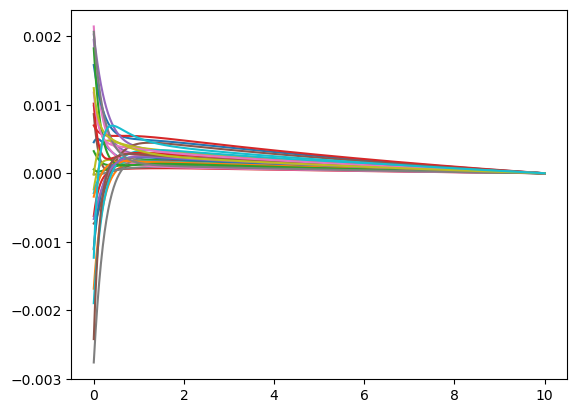

In [225]:
for i in range(nt.shape[0]):
    plt.plot(t,nt[i,:]-nt[i,-1])

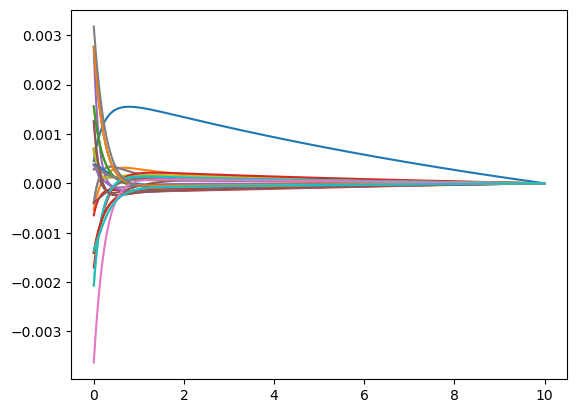

In [226]:
plot_eigenvectors(v,nt)

In [214]:
without_slow_mode = [n_f_dist(n_f,nt[:,i]) for i in range(nt.shape[1])]

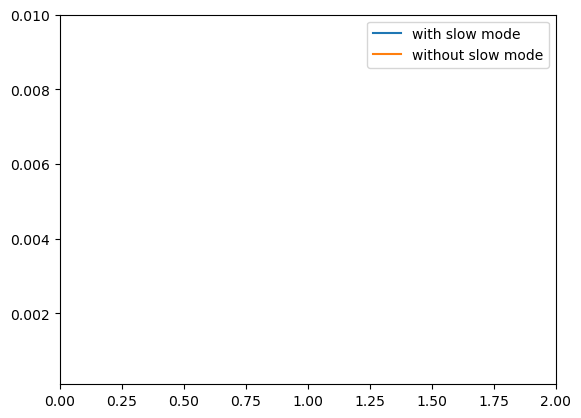

In [65]:
plt.plot([n_f_dist(n_f,nt[:,i]) for i in range(nt.shape[1])],label='with slow mode')
plt.plot(without_slow_mode,label='without slow mode')
plt.xlim([0,2])
plt.ylim([1E-4,1E-2])
plt.legend()
#plt.yscale('log')

In [67]:
n_perturbed = n_f +.005*(np.random.random(len(n_f)) - 0.5)
slow_v = np.real(v[:,0])
t_kick = 2
nt_pre, t_pre = sim_dyn(n_perturbed,t_kick)
t_f = 100
nt_post, t_post = sim_dyn(nt_pre[:,-1]+dn(slow_v,n_f,nt_pre[:,-1],-slow_v),t_f)

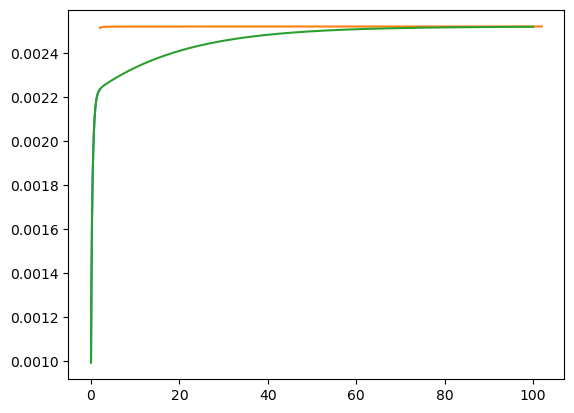

In [68]:
for i in range(1,2):
    plt.plot(t_pre,nt_pre[i,:])
for i in range(1,2):
    plt.plot(t_post+t_kick,nt_post[i,:])
t_f = 100
nt, t = sim_dyn(n_perturbed,t_f)
plt.plot(t,nt[i,:])

In [297]:
g = k.shape[0]
m = 10

#sig = np.random.random(g) - 0.5
#sig = sig/np.linalg.norm(sig)

#p = np.random.random(g) - 0.5
#p = p/np.linalg.norm(p)
T = 100
fitness = evaluate_fitness_controlled(n_f,2.1,m,p,sig,t_kick = 2)
fitnesses = [fitness]
went_downhill = 0
for kk in tqdm(range(200)):
    i, j = np.random.randint(g), np.random.randint(g)
    sig_new = np.array(sig)
    sig_new[i] = sig_new[i] + (np.random.rand() - 0.5)*4/5
    sig_new = sig_new/np.linalg.norm(sig_new)

    p_new = np.array(p)
    p_new[j] = p_new[j] + (np.random.rand() - 0.5)*4/10
    
    fitness_new = evaluate_fitness_controlled(n_f,2.1,m,p_new,sig_new,t_kick = 2)
    if fitness_new < fitness:
        fitness = fitness_new
        p = p_new
        sig = sig_new
    elif np.exp((fitness_new-fitness)/T) < np.random.rand():
        fitness = fitness_new
        p = p_new
        sig = sig_new
        went_downhill = went_downhill + 1
    fitnesses.append(fitness)


100%|███████████████████████████████████| 200/200 [01:03<00:00,  3.16it/s]


In [280]:
t_kick

2

100%|█████████████████████████████████████| 10/10 [00:34<00:00,  3.46s/it]


(array([1., 0., 0., 3., 0., 1., 0., 2., 0., 3.]),
 array([0.04212772, 0.04285853, 0.04358933, 0.04432014, 0.04505095,
        0.04578176, 0.04651257, 0.04724337, 0.04797418, 0.04870499,
        0.0494358 ]),
 <BarContainer object of 10 artists>)

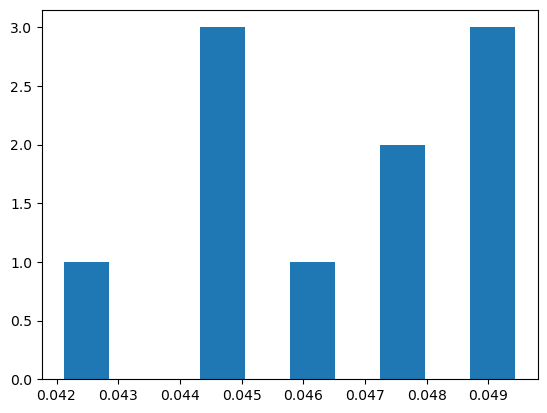

In [282]:
fitnesses_to_plot = []
for i in tqdm(range(10)):
    fitnesses_to_plot.append(evaluate_fitness_controlled(n_f,2.1,100,p,sig,t_kick = 2))
plt.hist(fitnesses_to_plot)

In [303]:
evaluate_fitness_controlled(n_f,2,m,p_new,sig_new,t_kick = 1)

0.0432525997074374

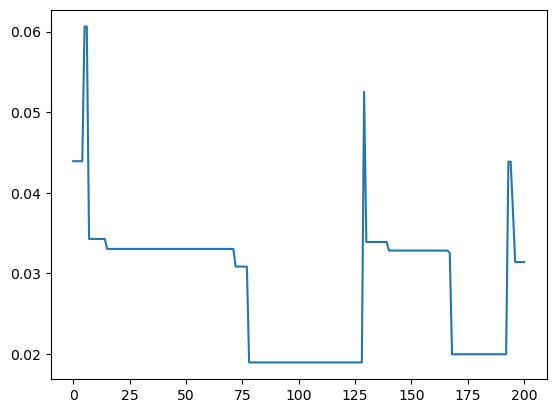

In [298]:
plt.plot(fitnesses)

In [1193]:
went_downhill

3

In [243]:
fitness

0.01982661790770188

In [288]:
p

array([-0.191989  ,  0.28301363, -0.08255263, -0.0574783 ,  0.21791697,
        0.19929272, -0.12868107, -0.04003999,  0.28158638, -0.08648401,
        0.17464105, -0.16579604, -0.18052123, -0.1867162 ,  0.23015843,
        0.25035062,  0.04176521, -0.26266025,  0.28898629,  0.04649149,
       -0.2631448 ,  0.1980348 ,  0.26194597,  0.11315537, -0.06871589,
       -0.02267611,  0.30648587,  0.024688  , -0.00217804, -0.08252189])

In [665]:
p

array([ 0.14680082,  0.23900294,  0.25646291,  0.00685267,  0.11771381,
       -0.05327914, -0.14785349, -0.08001352,  0.03798162,  0.27457565,
        0.01031807,  0.24342734, -0.2662958 ,  0.13698652,  0.00397759,
        0.05974495, -0.01719072,  0.19386078, -0.22787775,  0.09332233,
       -0.18611193,  0.21807573,  0.03184347, -0.06236367,  0.31589319,
        0.31358277, -0.13819264, -0.29393706, -0.2469513 , -0.02324051])

In [233]:
w


array([-0.05547437+0.j        , -1.75056224+0.j        ,
       -8.61523056+0.j        , -8.52868412+0.j        ,
       -8.34533042+0.j        , -2.20731513+0.j        ,
       -2.64205349+0.06921283j, -2.64205349-0.06921283j,
       -7.66727709+0.j        , -3.24336915+0.25019773j,
       -3.24336915-0.25019773j, -7.0583151 +0.15534574j,
       -7.0583151 -0.15534574j, -6.86310062+0.j        ,
       -3.51673045+0.j        , -3.60827939+0.j        ,
       -4.06373378+0.22516436j, -4.06373378-0.22516436j,
       -6.30550028+0.10187319j, -6.30550028-0.10187319j,
       -4.67191992+0.60230075j, -4.67191992-0.60230075j,
       -5.91954174+0.20420358j, -5.91954174-0.20420358j,
       -5.63019487+0.34842961j, -5.63019487-0.34842961j,
       -4.6282307 +0.j        , -4.91106839+0.j        ,
       -5.11672994+0.21350561j, -5.11672994-0.21350561j])

In [234]:
n_perturbed = n_f+.005*(np.random.random(len(n_f)) - 0.5)
t_kick = 2
nt_pre, t_pre = sim_dyn(n_perturbed,t_kick)
t_f = 100
nt_post, t_post = sim_dyn(nt_pre[:,-1]+dn(slow_v,n_f,nt_pre[:,-1],-slow_v),t_f)

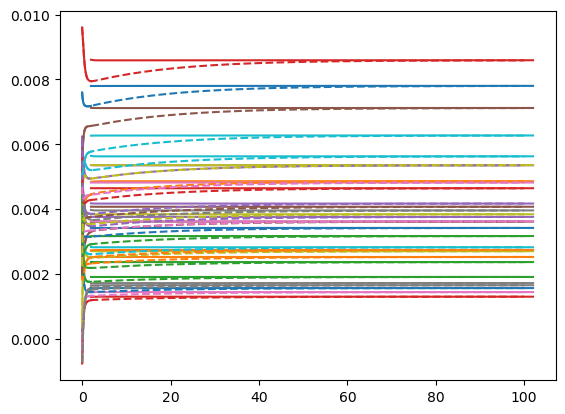

In [235]:
for i in range(nt.shape[0]):
    plt.plot(t_pre,nt_pre[i,:])
for i in range(nt.shape[0]):
    plt.plot(t_post+t_kick,nt_post[i,:])
nt, t = sim_dyn(n_perturbed,t_f)
for i in range(nt.shape[0]):
    plt.plot(t,nt[i,:],'--')

In [1125]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

In [236]:
evaluate_fitness_controlled(n_f,2,4,p,sig,t_kick = 1)

0.03134291340149664

In [296]:
np.dot(v[:,0],sig)/np.linalg.norm(sig)

(0.33033382865718164+0j)

In [ ]:
evaluate_fitness_controlled(n_f,2,m,p_new,sig_new,t_kick = 1)